In [1]:
import tensorflow as tf
import numpy as np
from galaxy2galaxy import problems
import matplotlib.pyplot as plt

In [2]:
fact = 100

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 2 arrays: an array of noisy galaxy images, 
    and an array of target galaxy images

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of noisy galaxy images, 
        and an array of target galaxy images
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    
    # Compute std of noise for a varying range of SNR
    # By definition - SNR(x) = max(x)/std(x)
    sigma_noise = (tf.math.reduce_max(tf.math.abs(dico['targets'])) / 
                   tf.random.uniform(shape=[], minval=1, maxval=50, dtype=tf.float32, seed=None))
    
    Noisemap = tf.random_normal(shape=(np.shape(dico['targets'])),
                                mean=0.0, 
                                stddev=sigma_noise, 
                                dtype=tf.float32)

    dico['inputs'] = dico['targets'] + Noisemap
    dico['inputs'] *= fact
    dico['targets'] *= fact

    return dico['inputs'], dico['targets']

In [3]:
# Let's create an instance of the meerkat_3600 problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('meerkat_3600')
dset = problem128.dataset(Modes.TRAIN, data_dir='/local/home/ua264756/Data/meerkat_3600')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)
n_batch = 32
dset = dset.batch(n_batch)

# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()

sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/meerkat_3600/meerkat_3600-train*
INFO:tensorflow:partition: 0 num_data_files: 50
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)

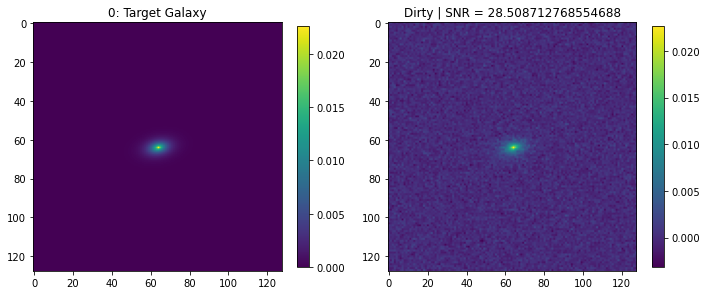

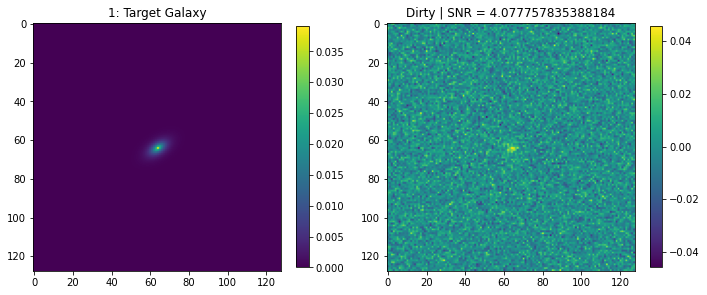

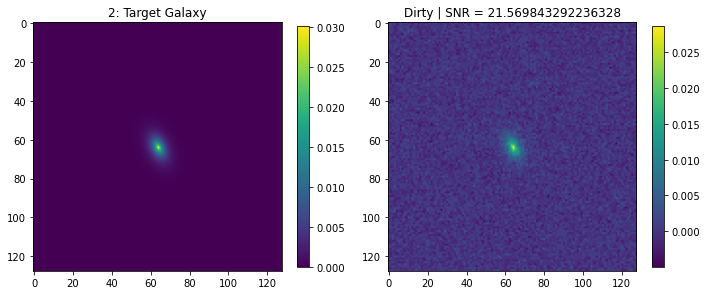

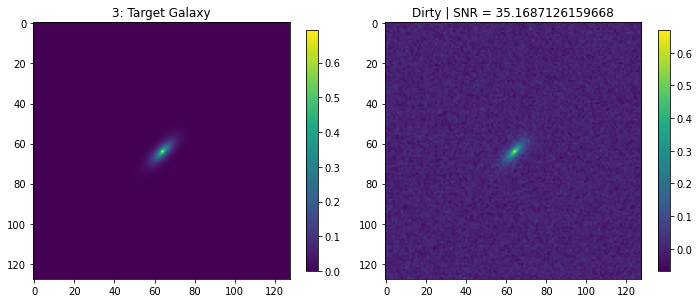

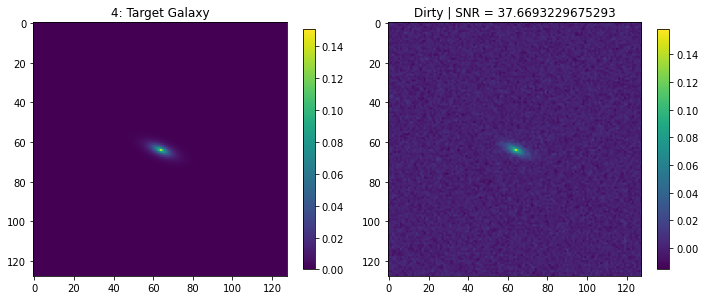

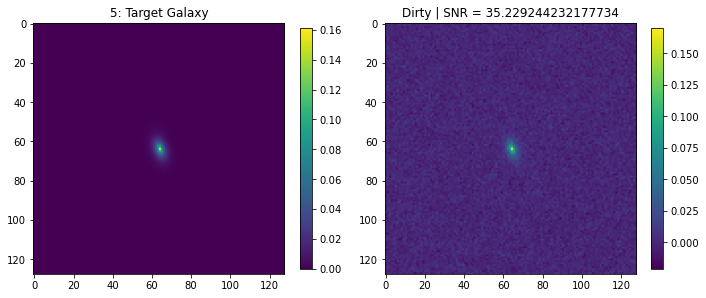

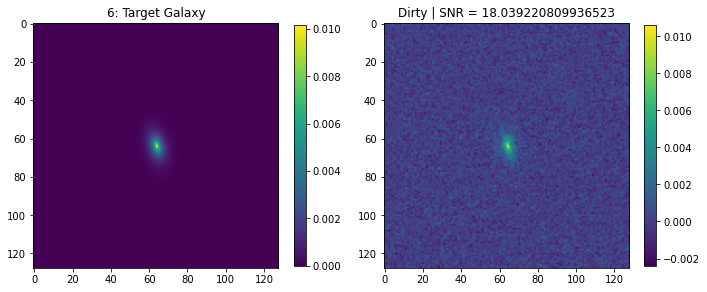

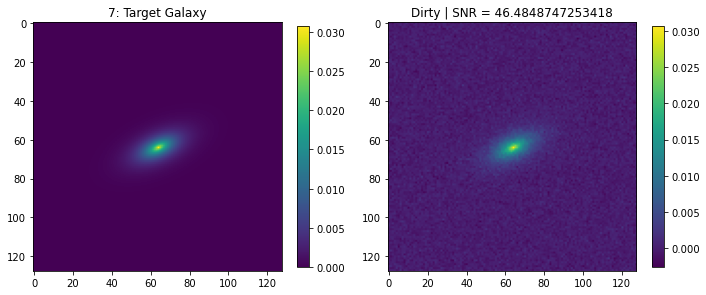

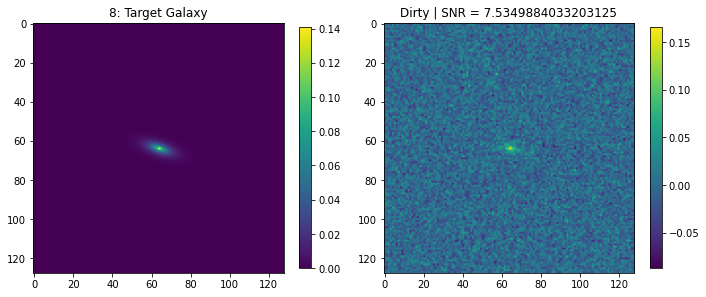

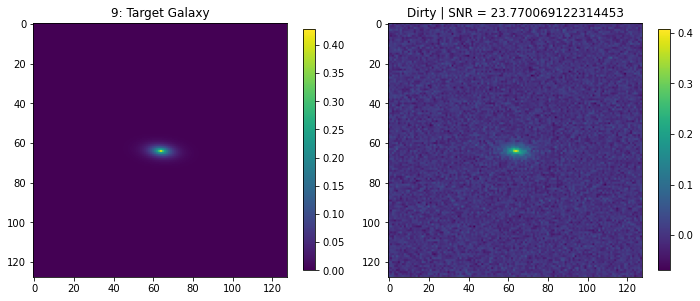

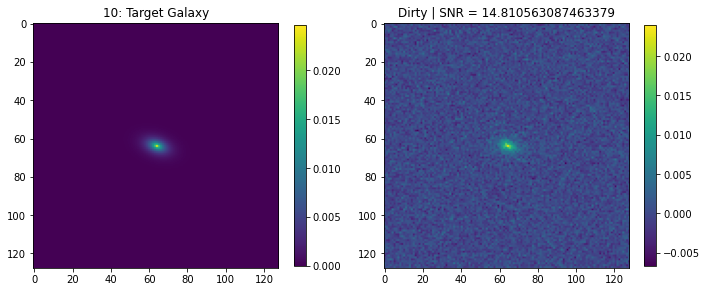

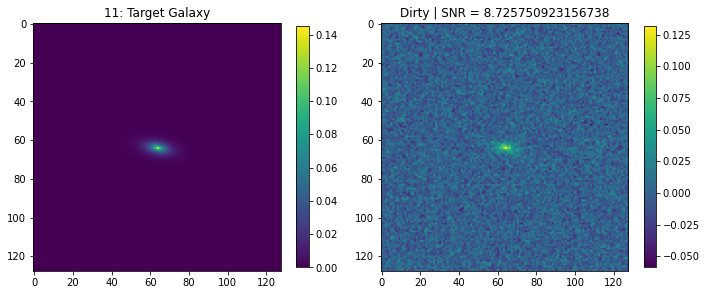

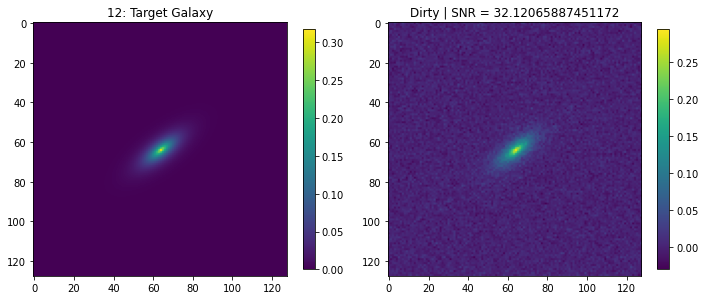

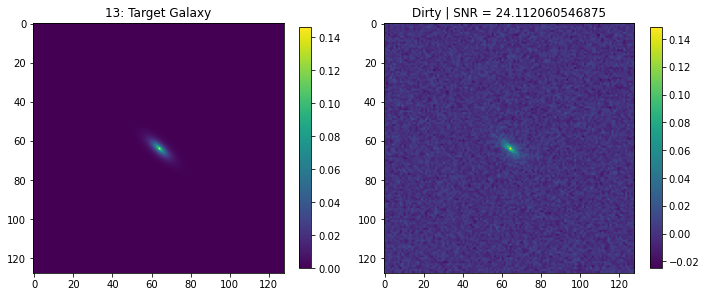

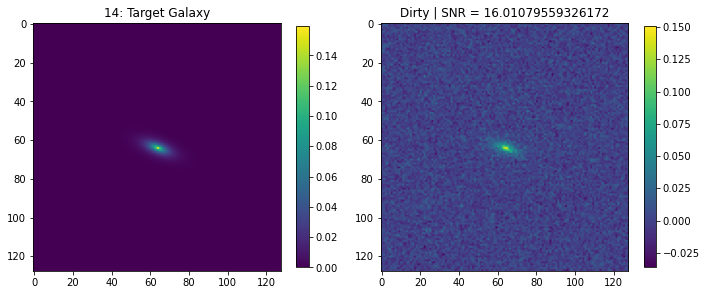

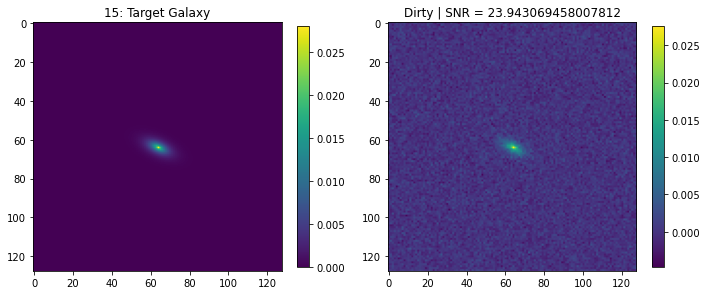

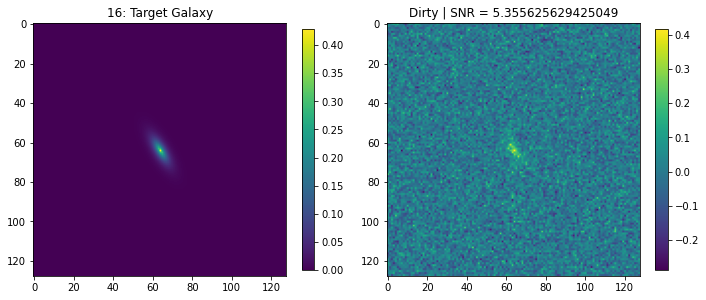

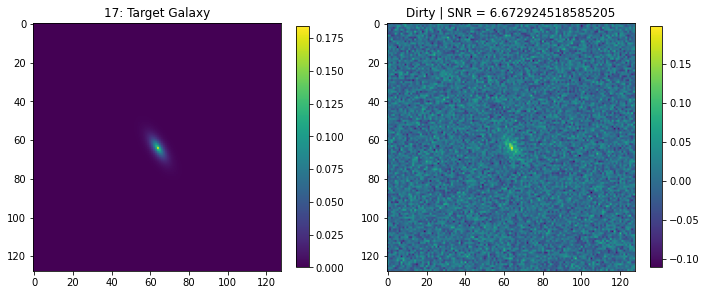

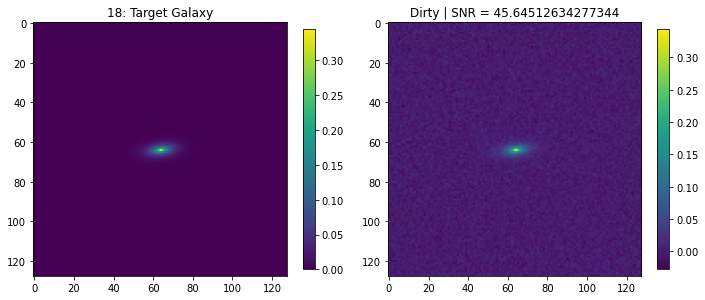

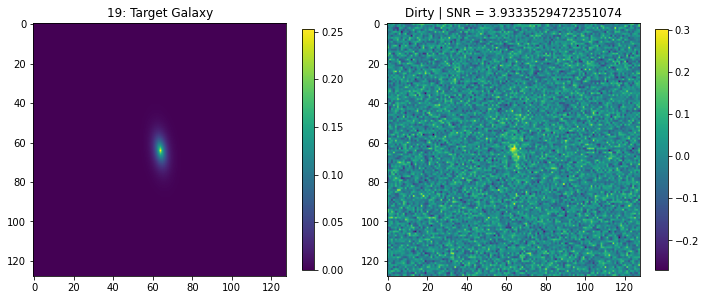

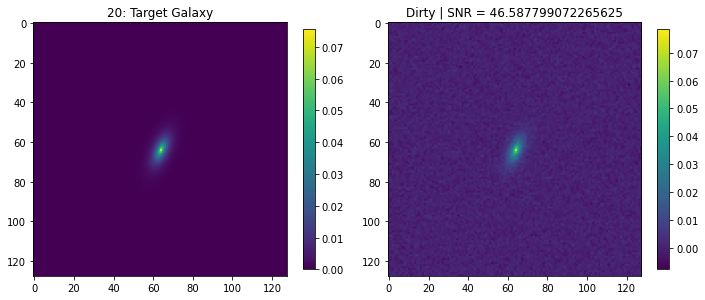

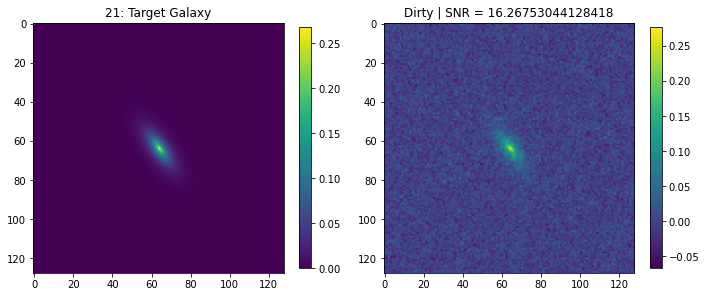

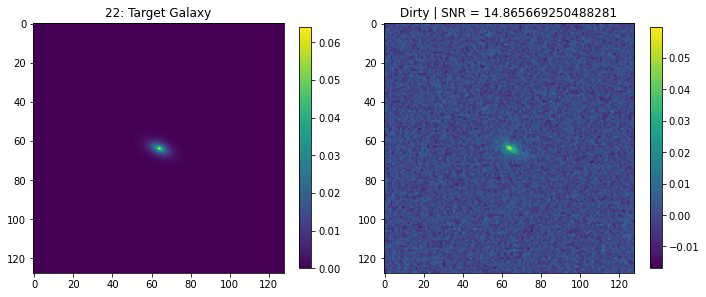

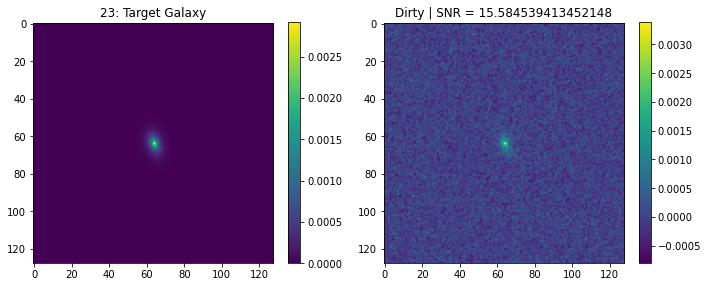

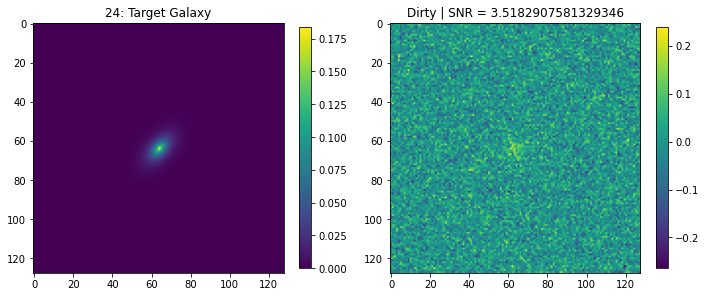

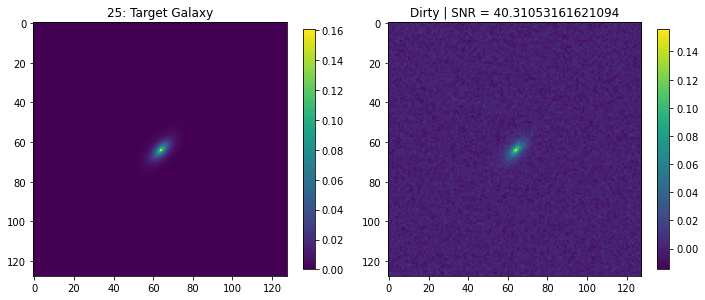

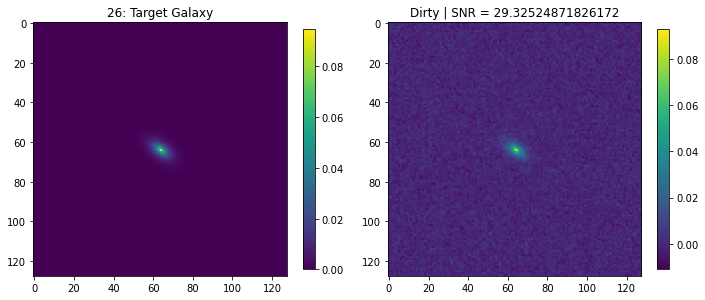

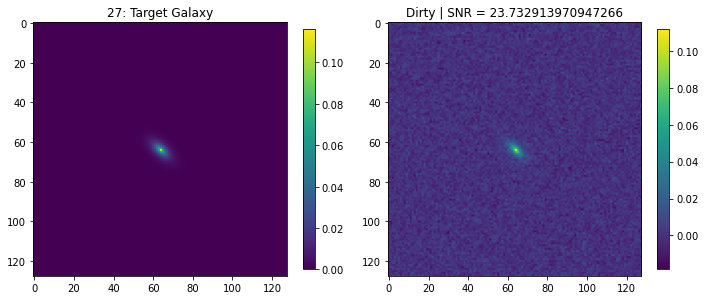

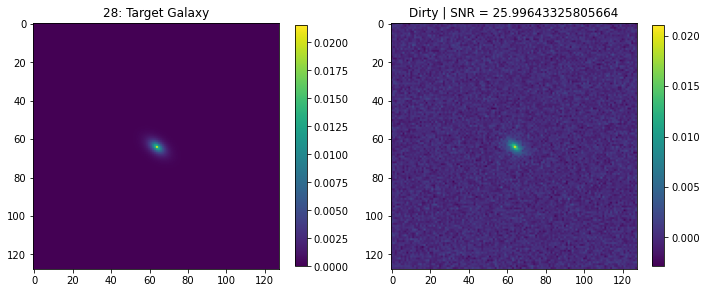

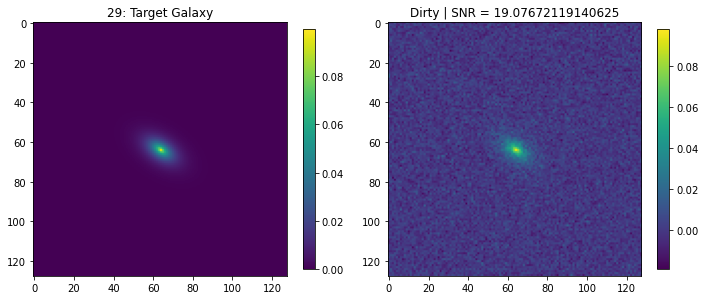

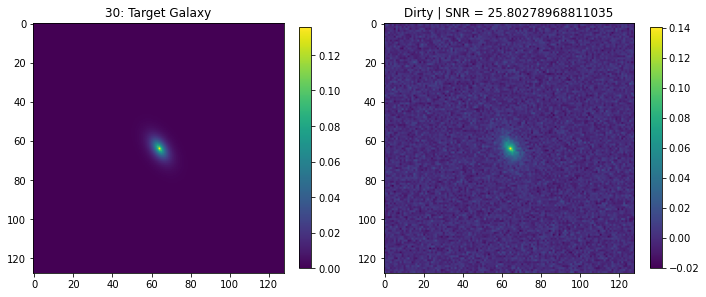

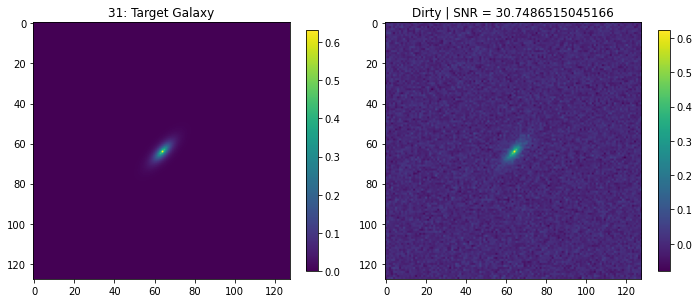

In [4]:
for i in range(n_batch):
    dirty = batch[0][i]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(np.squeeze(batch[1][i])); plt.colorbar(shrink=0.345); plt.title('{}: Target Galaxy'.format(i))
    plt.subplot(122)
    plt.imshow(np.squeeze(dirty)); plt.colorbar(shrink=0.345); plt.title('Dirty | SNR = {}'.format(SNR))
    plt.tight_layout()
    plt.show()

### U-Net

In [5]:
def DenseBlock(n_layers, n_kernels, input_layer, activation_function='swish',
               axis_concat=3, concat_input=True, dilation_rate=1):
    
    #concat_input: implies that we have a skip concatenation between input and output of block
    connect_input = input_layer
    
    for n in range(n_layers):
        
        bn = tf.keras.layers.BatchNormalization()(connect_input)
        act = tf.keras.layers.Activation(activation_function)(bn)
        conv = tf.keras.layers.SeparableConv2D(n_kernels, 3, padding='same', use_bias=False,
                                               kernel_initializer='he_uniform')(act)
        if n == 0:
            concat = conv
        else:
            concat = tf.keras.layers.Concatenate(axis = axis_concat)([concat, conv])
        
        connect_input = concat
        
    if concat_input:
        return tf.keras.layers.Concatenate(axis = axis_concat)([input_layer, concat])
    
    return concat


# Define the modified U-net
img_rows = img_cols = 128
nb_scales = 4
growth_rate = 12
nb_layers_per_block = [4,5,6,7]
activation_function= 'relu'
gamma=1


# NETWORK CONSTRUCTION STARTS HERE
inputs = tf.keras.Input(shape=[img_rows, img_cols, 1])


# INPUT CONV
net = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_uniform')(inputs)


# CONTRACTING PATH
skip_connect = []

for scale in range(nb_scales-1):
    
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                       n_kernels=growth_rate,
                       input_layer=net,
                       activation_function=activation_function,
                       concat_input=True)
    
    skip_connect.append(block)
    batch_norm = tf.keras.layers.BatchNormalization()(block)
    activation = tf.keras.layers.Activation(activation_function)(batch_norm)
    
    conv_transi = tf.keras.layers.Conv2D(32+np.sum(nb_layers_per_block[:scale+1])*growth_rate, 1, padding='same', 
                                         use_bias=False, kernel_initializer='he_uniform')(activation)
    
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv_transi)

    
# BOTTLENECK
block = DenseBlock(n_layers=nb_layers_per_block[-1],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)


# EXPANSIVE PATH
for scale in range(nb_scales-2, -1, -1):   
    
    up = tf.keras.layers.Conv2D(nb_layers_per_block[scale+1]*growth_rate, 2, activation = activation_function,
             padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(block))
    
    net = tf.keras.layers.Concatenate(axis = 3)([up, skip_connect[scale]])
    
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                       n_kernels=growth_rate,
                       input_layer=net,
                       activation_function=activation_function,
                       concat_input=False)

    
# FUSION AND SKIP CONNECT
batch_norm = tf.keras.layers.BatchNormalization()(block)
activation = tf.keras.layers.Activation(activation_function)(batch_norm)
outputs = tf.keras.layers.Conv2D(1, 1, activation = 'linear')(activation)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compile the model

In [6]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
history = model.fit(dset, steps_per_epoch=6250, epochs=20)

Train on 6250 steps
Epoch 1/20
6250/6250 [==============================] - 3923s 628ms/step - loss: 4.5294e-04 - acc: 2.5145e-05
Epoch 2/20
6250/6250 [==============================] - 4039s 646ms/step - loss: 1.1757e-05 - acc: 2.5145e-05
Epoch 3/20
6250/6250 [==============================] - 3913s 626ms/step - loss: 6.7144e-06 - acc: 2.5145e-05
Epoch 4/20
6250/6250 [==============================] - 4034s 645ms/step - loss: 7.0371e-06 - acc: 2.5145e-05
Epoch 5/20
6250/6250 [==============================] - 3912s 626ms/step - loss: 4.2459e-06 - acc: 2.5145e-05
Epoch 6/20
6250/6250 [==============================] - 4033s 645ms/step - loss: 4.6694e-06 - acc: 2.5145e-05
Epoch 7/20
6250/6250 [==============================] - 3912s 626ms/step - loss: 3.8104e-06 - acc: 2.5145e-05
Epoch 8/20
6250/6250 [==============================] - 4027s 644ms/step - loss: 3.3520e-06 - acc: 2.5145e-05
Epoch 9/20
6250/6250 [==============================] - 3906s 625ms/step - loss: 2.9494e-06 - acc: 2

In [9]:
model.save('Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}')

### Results

dict_keys(['loss', 'acc'])


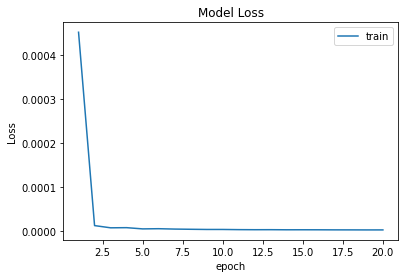

In [10]:
print(history.history.keys())

plt.plot(range(1,21), history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

In [11]:
# The model can be applied like so
res = model(batch[0].astype('float32'))

# This should return the solution of the denoising problem
res_np = tf.keras.backend.eval(res).squeeze(axis=-1)  

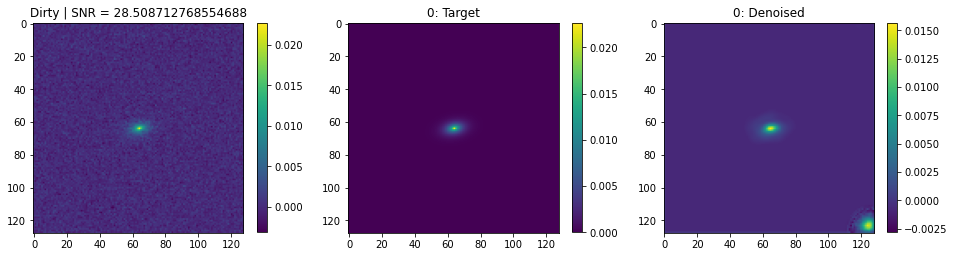

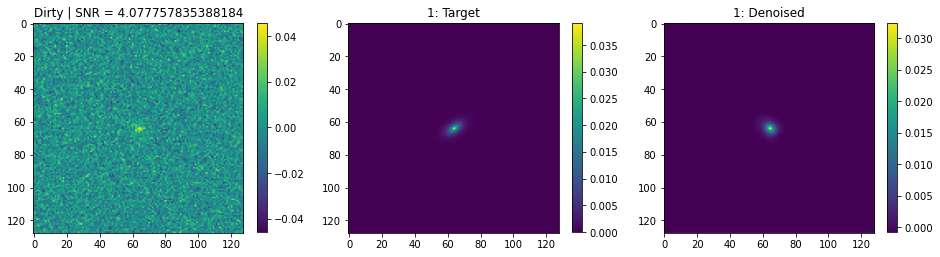

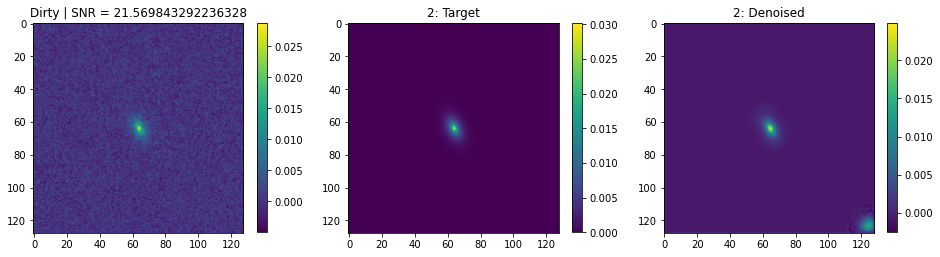

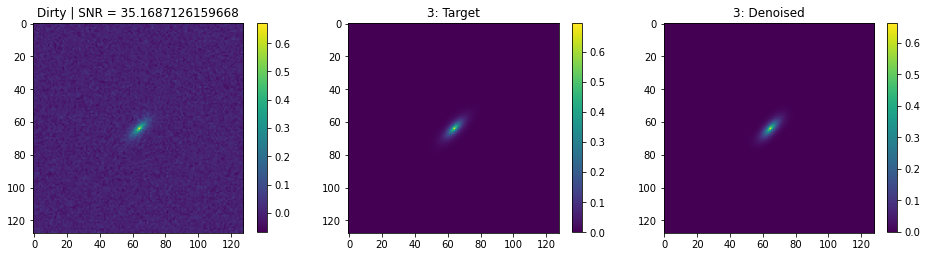

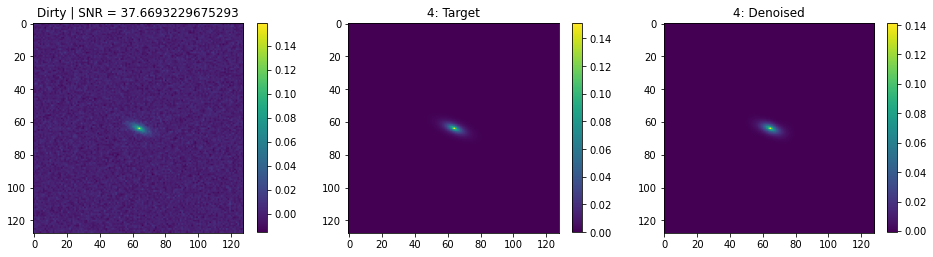

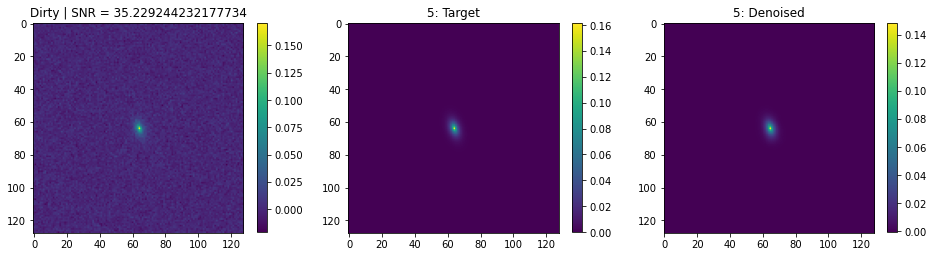

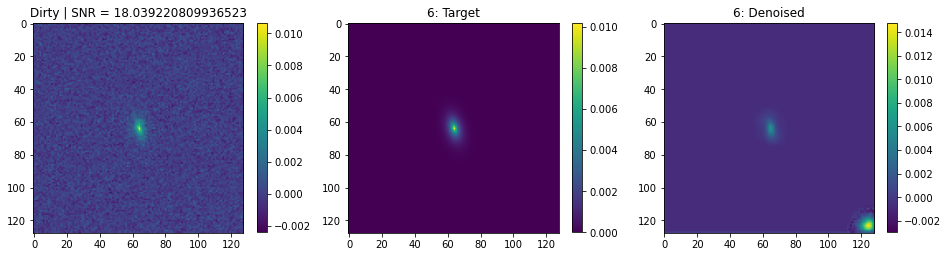

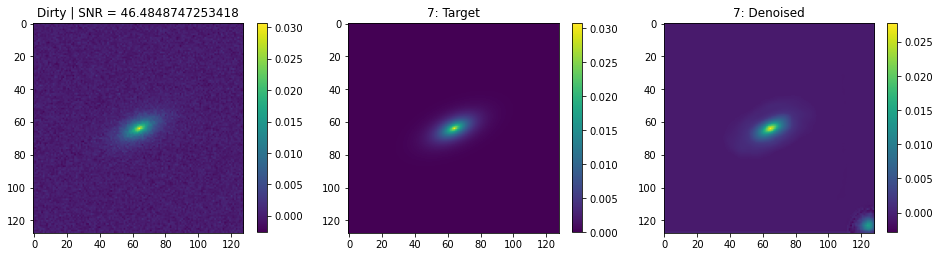

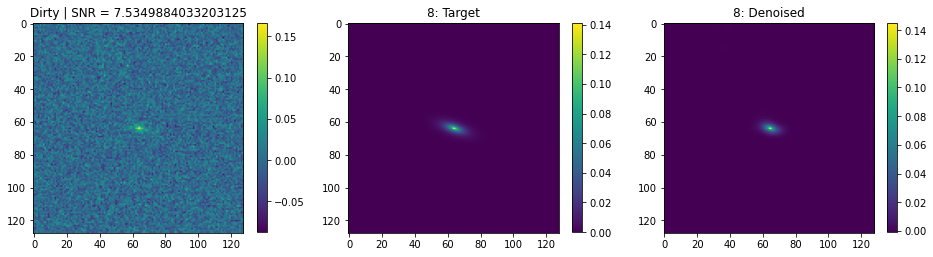

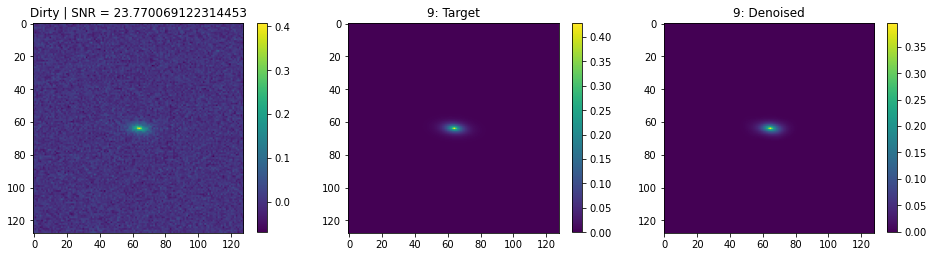

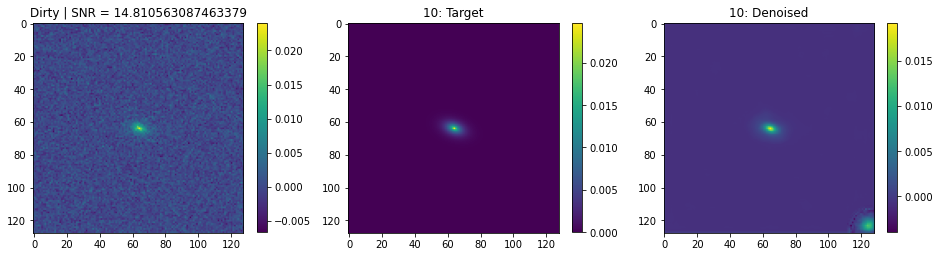

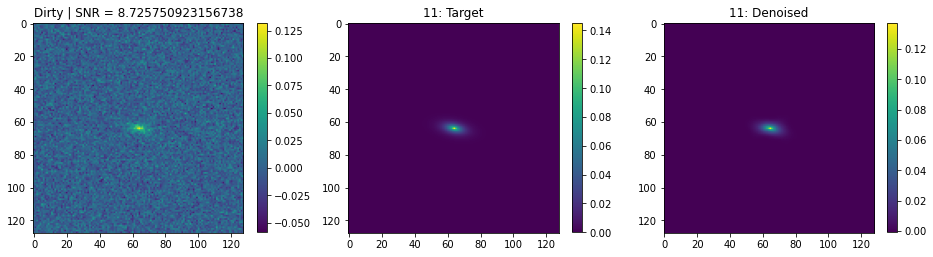

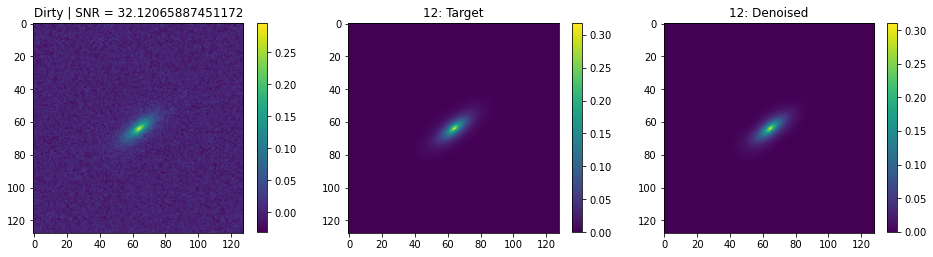

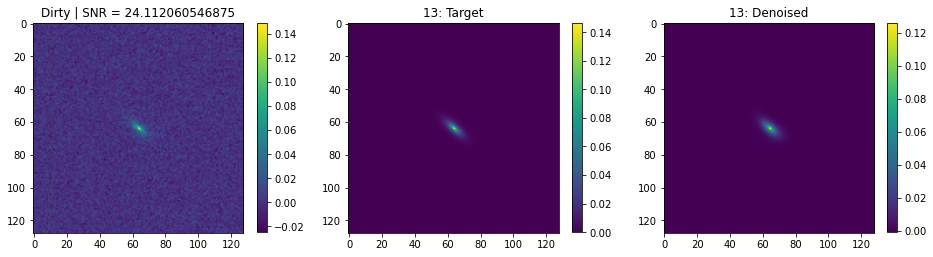

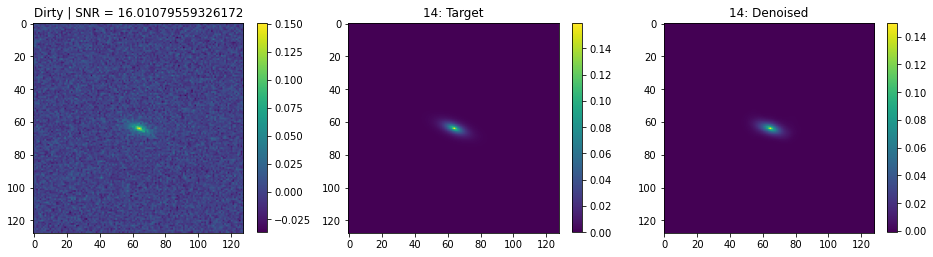

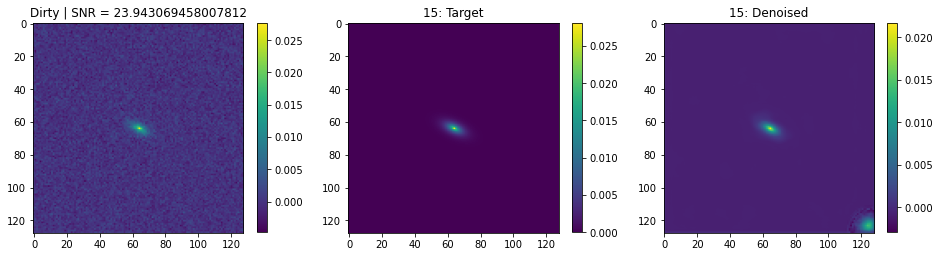

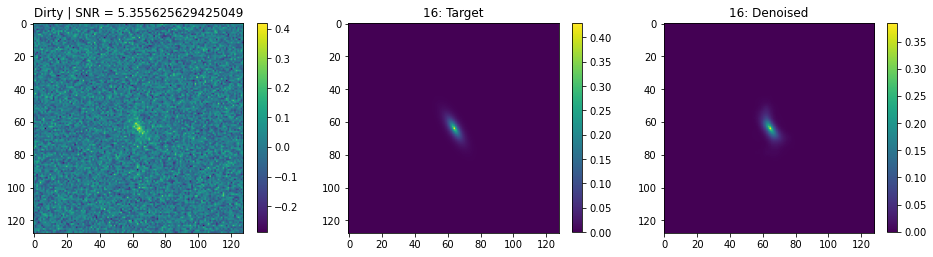

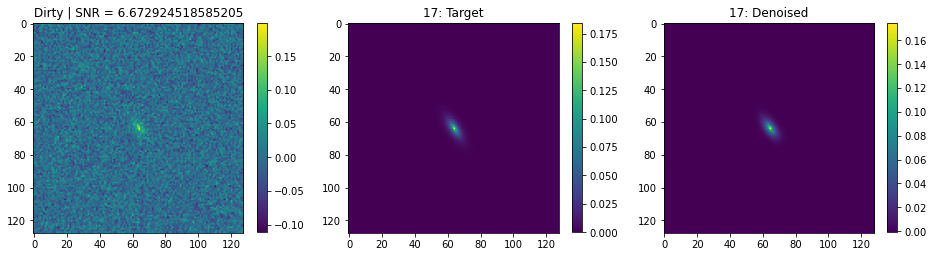

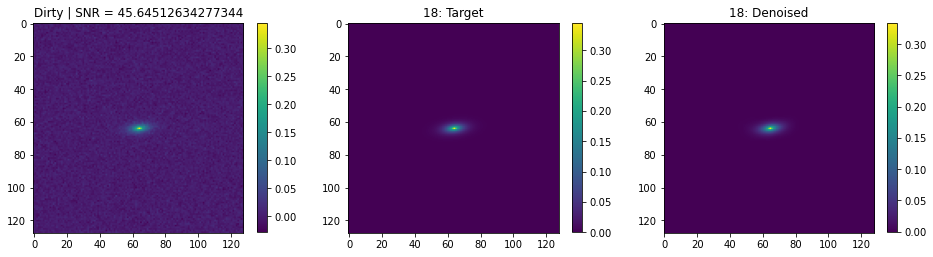

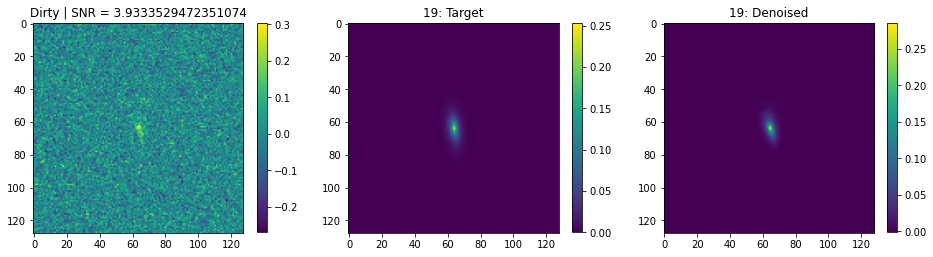

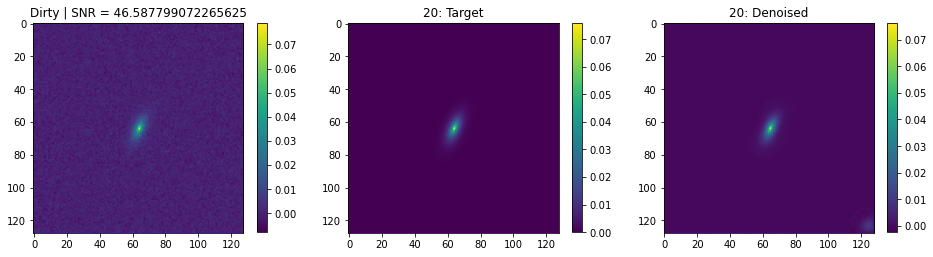

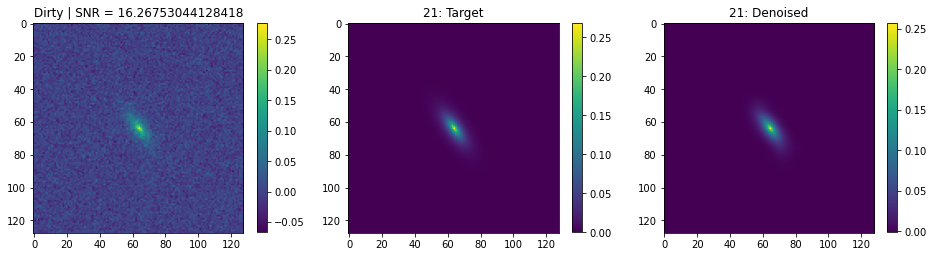

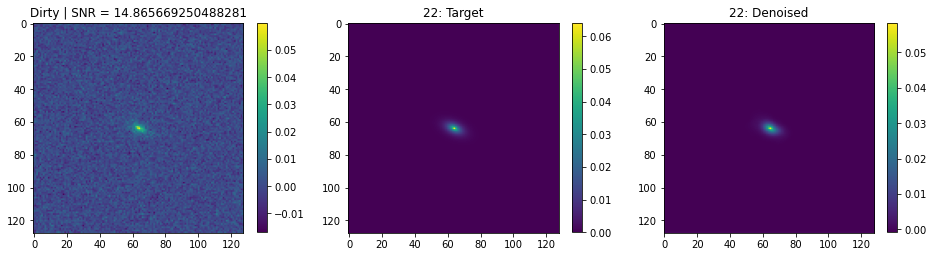

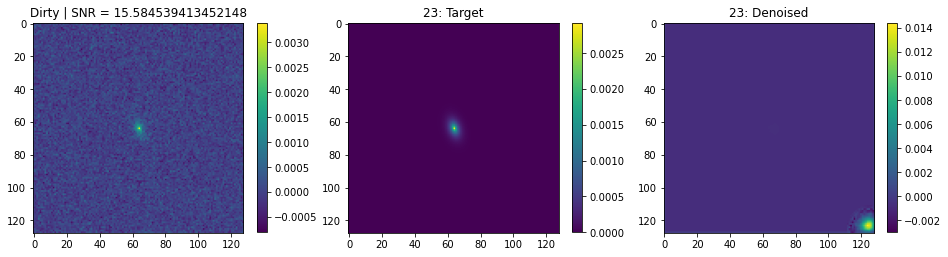

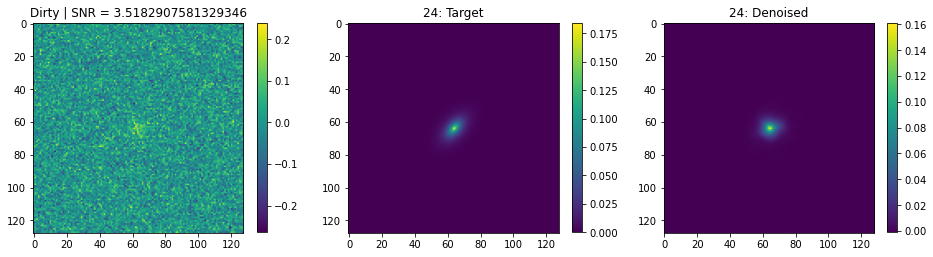

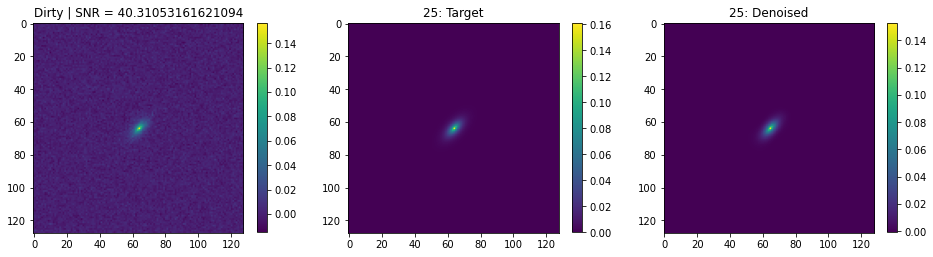

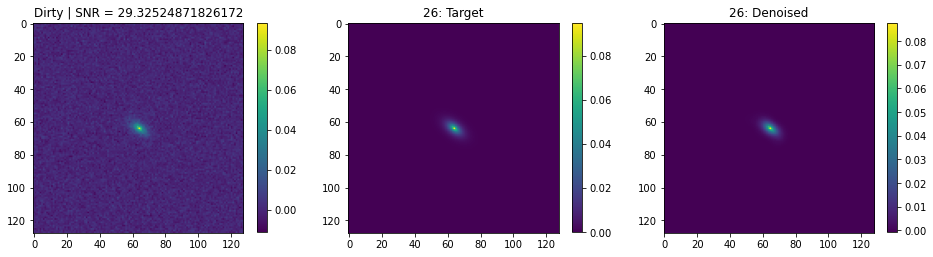

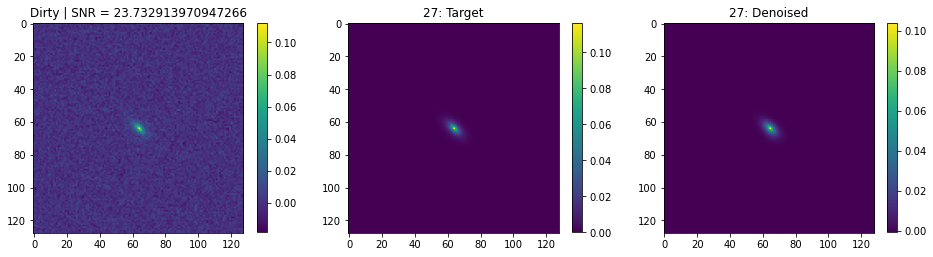

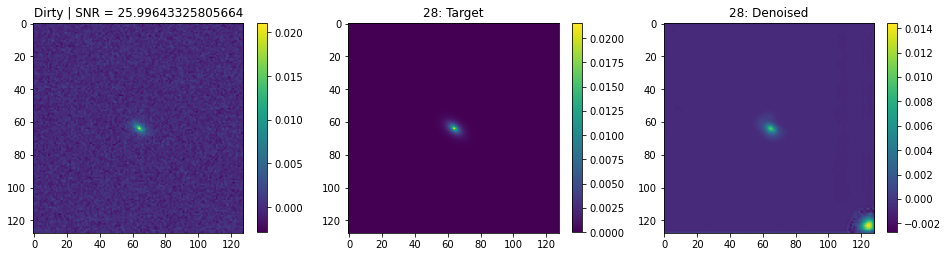

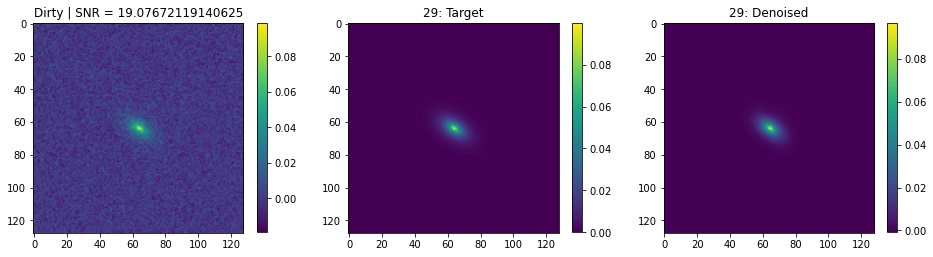

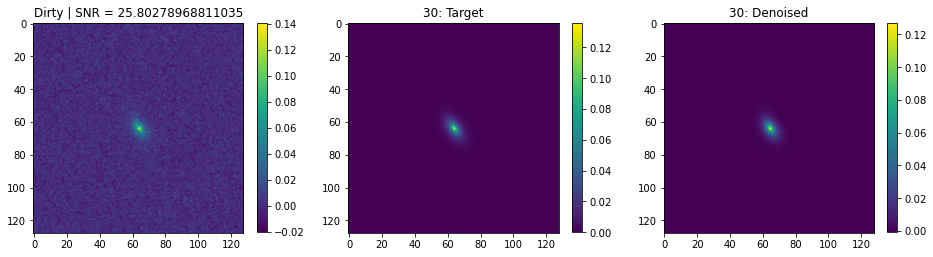

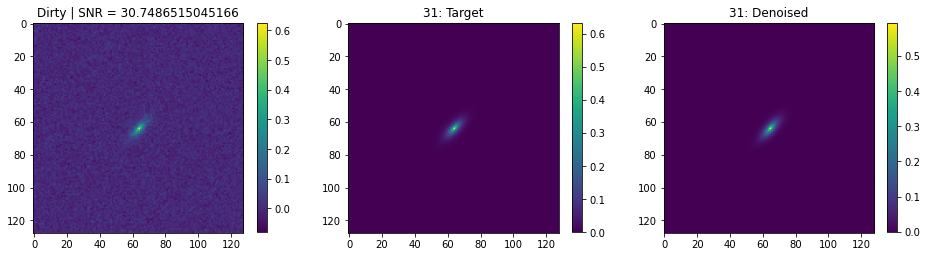

In [12]:
# Look at a few results
for index in range(n_batch):
    dirty = batch[0][index]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    fig = plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(dirty.squeeze(axis=-1))
    plt.title('Dirty | SNR = {}'.format(SNR))
    plt.colorbar(shrink=0.24)
    plt.subplot(132)
    plt.imshow(batch[1][index].squeeze(axis=-1))
    plt.title('{}: Target'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(133)
    plt.imshow(res_np[index])
    plt.title('{}: Denoised'.format(index))
    plt.colorbar(shrink=0.24)
    plt.show(fig)    